<center>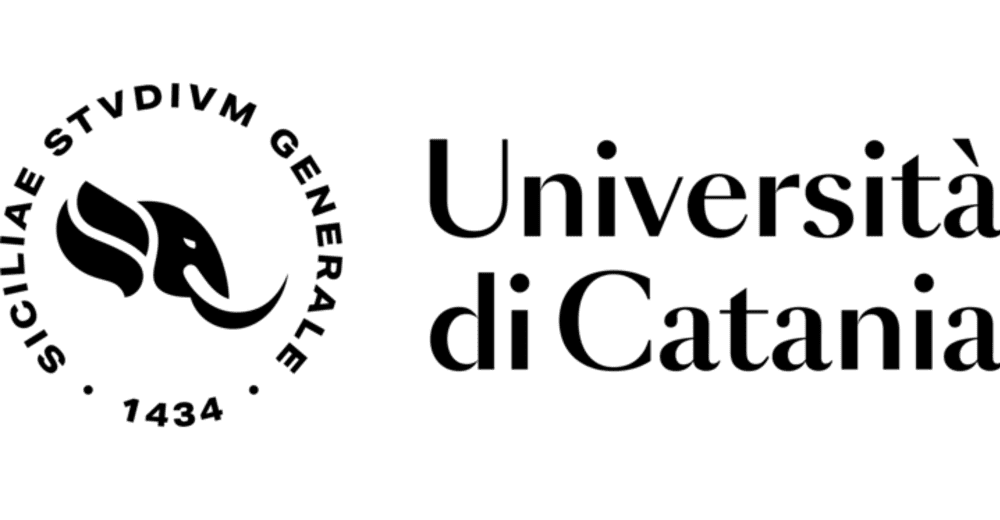

<center><h3>DATA SCIENCE FOR MANAGEMENT - LM 91</h3>
<h1>Covid-19 Classification using CNNs</h1>

## 1. Introduction

AI-enabled Medical Image Analysis (MIA) Workshop is devoted to medical image analysis, with emphasis on radiological quantitative image analysis for diagnosis of diseases. The focus is on Artificial Intelligence (AI), Machine and Deep Learning (ML, DL) approaches that target effective and adaptive diagnosis; there is also a particular interest in approaches that enforce trustworthiness and automatically generate explanations, or justifications of the decision making process.

COV19D Competition is based on a database of chest CT scan series that is manually annotated with respect to Covid-19/non-Covid-19 diagnosis.

The aim of this Computer Vision project is to build a classifier using some models CNNs on PyTorch to classify ct scans of covid and non-covid patients.

The dataset consists of ct scans of 1926 patients, split in:

**Training set**
- 687 Covid patients with 153.680 ct scan slices
- 865 Non-covid patients with 181.991 ct scan slices

**Validation set**
- 165 Covid patients with 35.002 ct scan slices
- 209 Non-covid patients with 40.516 ct scan slices

<span style="color:red">**Please note: Test set will be created using the 10% of the training set**</span>

### 1.1 Required libraries

We load all the libraries that will be used during the analysis:

In [ ]:
%matplotlib inline
from IPython.display import clear_output

import os
import glob
import sys
import time
import re

from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import *
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
torch.manual_seed(21)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2

import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
np.random.seed(21)

import random
random.seed(21)

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### 1.2 Download the dataset

The whole dataset size is ~40GB, first of all we need to create a dataset folder:

In [ ]:
!mkdir dataset

Then, data are downloaded from Google Cloud Storage Bucket and unzipped to the dataset folder:

In [ ]:
!gsutil cp gs://covid_19_challenge/train.zip .
!unzip -q train.zip -d dataset

The same apply to the validation set:

In [ ]:
!gsutil cp gs://covid_19_challenge/val.zip .
!unzip -q val.zip -d dataset

And delete the zip files to free space!

In [ ]:
!rm -f train.zip
!rm -f val.zip

## 2. The dataset

### 2.1 Dataset information

Before starting to analyze the dataset should be useful to keep track about file size, this should create same problem during the training:

In [ ]:
dir = './dataset/'

size_file = list()
path_file = []

# Get a list of files (file paths) in the given directory 
list_of_files = filter(os.path.isfile, glob.glob(dir + '/**/*', recursive=True))

# get list of ffiles with size
files_with_size = [(file_path, os.stat(file_path).st_size) for file_path in list_of_files]

files_with_size = pd.DataFrame(files_with_size)

In [ ]:
files_with_size.sort_values(by=[1], ascending = True).head(20)

,0,1
15147,./dataset/val/covid/ct_scan_34/236.jpg,3404
15266,./dataset/val/covid/ct_scan_34/227.jpg,3404
15267,./dataset/val/covid/ct_scan_34/243.jpg,3404
15200,./dataset/val/covid/ct_scan_34/247.jpg,3404
15194,./dataset/val/covid/ct_scan_34/241.jpg,3404
15281,./dataset/val/covid/ct_scan_34/249.jpg,3404
15283,./dataset/val/covid/ct_scan_34/229.jpg,3404
15302,./dataset/val/covid/ct_scan_34/234.jpg,3404
15159,./dataset/val/covid/ct_scan_34/223.jpg,3404
15145,./dataset/val/covid/ct_scan_34/238.jpg,3404


As we can see there are many files with small size, investigating more showed us that these images are black and we can remove it

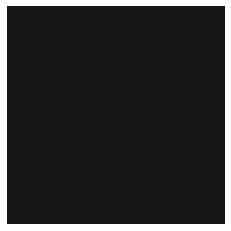

In [ ]:
img = cv2.imread('./dataset/val/covid/ct_scan_34/249.jpg')[:,:,::-1]
plt.axis("off")
plt.imshow(img)

In [ ]:
!rm -f dataset/val/covid/ct_scan_34/221.jpg
!rm -f dataset/val/covid/ct_scan_34/223.jpg
!rm -f dataset/val/covid/ct_scan_34/225.jpg
!rm -f dataset/val/covid/ct_scan_34/227.jpg
!rm -f dataset/val/covid/ct_scan_34/229.jpg
!rm -f dataset/val/covid/ct_scan_34/232.jpg
!rm -f dataset/val/covid/ct_scan_34/234.jpg
!rm -f dataset/val/covid/ct_scan_34/236.jpg
!rm -f dataset/val/covid/ct_scan_34/238.jpg
!rm -f dataset/val/covid/ct_scan_34/241.jpg
!rm -f dataset/val/covid/ct_scan_34/243.jpg
!rm -f dataset/val/covid/ct_scan_34/245.jpg
!rm -f dataset/val/covid/ct_scan_34/247.jpg
!rm -f dataset/val/covid/ct_scan_34/249.jpg
!rm -f dataset/train/covid/ct_scan_263/271.jpg

Also, during the training phase we found some errors related to two files that are corrupted, and we decided to remove them:

In [ ]:
!rm -f dataset/val/non-covid/ct_scan_9/._9.jpg
!rm -f dataset/val/non-covid/ct_scan_9/._92.jpg

Let's have a look at what there is inside the training, validation and test set folders and the number of patients and slices for each set:

In [ ]:
sets = []
classes = []
n_patients = list()
n_slices = list()
avg_slices = list()

for split in ['train', 'val']:
    for folder in sorted(os.listdir(dir + split)):
        sets.append(split)
        classes.append(folder)

        patients = len(os.listdir(dir + split + '/' + folder))
        n_patients.append(patients)

        slices = sum(len(files) for _, _, files in os.walk(dir + split + '/' + folder))
        n_slices.append(slices)

        avg_slice = round(slices/patients)
        avg_slices.append(avg_slice)

dataset_composition = { "Set": sets, "Class": classes, "Number of Patients": n_patients, "Number of slices": n_slices, "Average number of slices": avg_slices}
df_dataset_composition = pd.DataFrame(dataset_composition)
df_dataset_composition.head(10)

,Set,Class,Number of Patients,Number of slices,Average number of slices
0,train,covid,687,153680,224
1,train,non-covid,865,181991,210
2,val,covid,165,35002,212
3,val,non-covid,209,40516,194


As we can see there are two folders for each set: covid and non-covid. Although the number of patients is balanced, number of slices and average number of slices per patients are not balanced.

### 2.2 Preparing the dataset to be analyzed

Considering that samples provided within the dataset have various dimensions, we decided to resize them all to 224x224, applying a normalization with mean and standard deviation at 0.5. Normalize will bring the image in the range [-1,1] and this could be helpful for the CNN.

In [ ]:
transform = T.Compose([
          T.Resize((224, 224)),
          T.ToTensor(),
          T.Normalize(0.5, 0.5)
])

Apply the transformation to training and validation set:

In [ ]:
dir = './dataset/'

In [ ]:
train_set = datasets.ImageFolder(dir + "train", transform=transform)
val_set = datasets.ImageFolder(dir + "val", transform=transform)

Now, we create the test set taking 10% of samples from the training set:

In [ ]:
train_size = int(0.9 * len(train_set))
test_size = len(train_set) - train_size
train_set, test_set = torch.utils.data.random_split(train_set, [train_size, test_size])

# Dataset len
num_train = len(train_set)
num_val = len(val_set)
num_test = len(test_set)
print(f"Number of training samples:   {num_train}")
print(f"Number of validation samples: {num_val}")
print(f"Number of test samples:       {num_test}")

Number of training samples:   302103
Number of validation samples: 75518
Number of test samples:       33568


We can define how to load the data and we decided to load them with a batch size of 32 dropping the last batch and shuffling only the training set.

<span style="color:red">**Please note: batch size of 32 is applied only for the FCN, for pretrained models is raised to 64.**</span>

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False, num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, drop_last=False, num_workers=4)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, drop_last=False, num_workers=4)

As we can see the set has been correctly loaded, showing the two classes:

In [ ]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


And as we can see the data from training set have been loaded correctly and we have a tensor of 32x3x224x224, which means:
*   Batch size: 32
*   Channels: 3 (RGB) - Although images are grayscale
*   Height: 224px
*   Width: 224px

### 2.3 Image samples

And now we can see 32 samples in the first batch loaded:

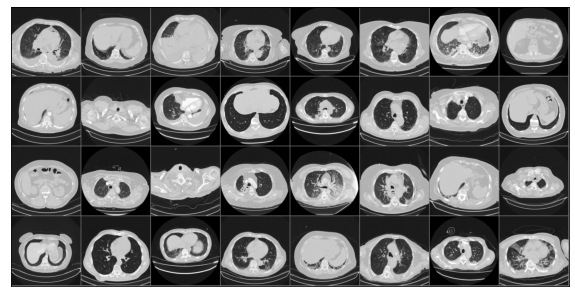

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig= plt.figure(figsize=(10,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(inputs))

## 3. The architectures

In this chapter will be compared differenct known pre-trained architecture such as VGG16, ResNet-152, DenseNet-161 versus an "homemade" Fully Convolutional Network trained from scratch.

### 3.1 Classification

Here we define the training function to train, validate and test the model.

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=25, dev=torch.device("cpu"), save_param = False, model_name="my_model"):
    
    history_prediction = []
    history_label = []
    history_epoch = list()
    
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}

        # Store the best validation test accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            
            # Store predictions and labels for each batch
            batch_prediction = {"train": [], "val": [], "test": []}
            batch_label = {"train": [], "val": [], "test": []}
            
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split], desc = ' {} {} '.format(split, epoch+1)):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)


                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy

                    # Store predictions and labels for each batch
                    batch_prediction[split].extend(pred_labels.tolist())
                    batch_label[split].extend(labels.tolist())

            # Store predictions and labels for each epoch
            history_prediction.append(batch_prediction)
            history_label.append(batch_label)

            history_epoch.append(epoch+1)

            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])


            # Print info
            print(f"Epoch {epoch+1}:",
                  f"Training Loss={epoch_loss['train']:.4f},",
                  f"Training Accuracy={epoch_accuracy['train']:.4f},",
                  f"Validation Loss={epoch_loss['val']:.4f},",
                  f"Validation Accuracy={epoch_accuracy['val']:.4f},",
                  f"Test Loss={epoch_loss['test']:.4f},",
                  f"Test Accuracy={epoch_accuracy['test']:.4f}")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        print()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

        # Create dataframe from dictionaries
        dict_accuracy = { "Model": model_name, "Epoch": history_epoch, "Train Accuracy": history_accuracy['train'], "Val Accuracy": history_accuracy['val'], "Test Accuracy": history_accuracy['test']}
        df_accuracy = pd.DataFrame(dict_accuracy)
        # Start index of the dataframe from 1 (as for the number of epoch)
        df_accuracy.index += 1

        # Set pandas to display the whole dataframe
        pd.set_option('display.max_columns', None)

        # Best model for validation accuracy
        val_best_model = df_accuracy.loc[[df_accuracy["Val Accuracy"].idxmax()]]
        print("\n*** Best model: ***")
        print(val_best_model)
        
        for split in ["train", "val", "test"]:
          print(f"\n{model_name} - Confusion Matrix " + split + " set")
          mat = confusion_matrix(history_prediction[(df_accuracy["Val Accuracy"].idxmax()-1)][split], history_label[(df_accuracy["Val Accuracy"].idxmax()-1)][split]) #Pay attention that this confusion matrix is actually reversed
          sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar= True, xticklabels=['covid','non-covid'], yticklabels=['covid','non-covid'])
          plt.ylabel('Actual class') #Pay attention that this confusion matrix is actually reversed and this is original x-axis
          plt.xlabel('Predictions') #Pay attention that this confusion matrix is actually reversed and this is original y-axis
          plt.show()    
          print(metrics.classification_report(history_label[(df_accuracy["Val Accuracy"].idxmax()-1)][split], history_prediction[(df_accuracy["Val Accuracy"].idxmax()-1)][split], zero_division = 0, target_names=['covid','non-covid']))
          plt.clf()

        return (val_best_model)

We define the dictionary for loaders, the criterion, optimizer and the number of epochs (which is 5 for every model used).

At the end of each training will be print the best model for epoch considering the accuracy over the validation set, a confusion matrix over all the three sets and other parameters to evaluate the goodness of the model.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}
           
criterion = nn.CrossEntropyLoss()

### 3.2 Fully Convolutional Network

Fully Convolutional Network is a network that does not contain any dense layer, as in traditional Convolutional Neural Network, instead containes 1x1 convolutions that perform the task of the dense layer.

It is composed by 5 layer, with kernel size 3x3, padding and striding 1.
The number of channels is doubled at each layer, starting from 64 to 512. The activation function used is ReLu with Max pooling of size 2x2 and striding 2.

Due to the lack of final dense layer as classifier we used a convolutional layer of 512, kernel size 2x2, padding 0 and striding 1, that will be able to classify images in the 2 predefined classes.

<center>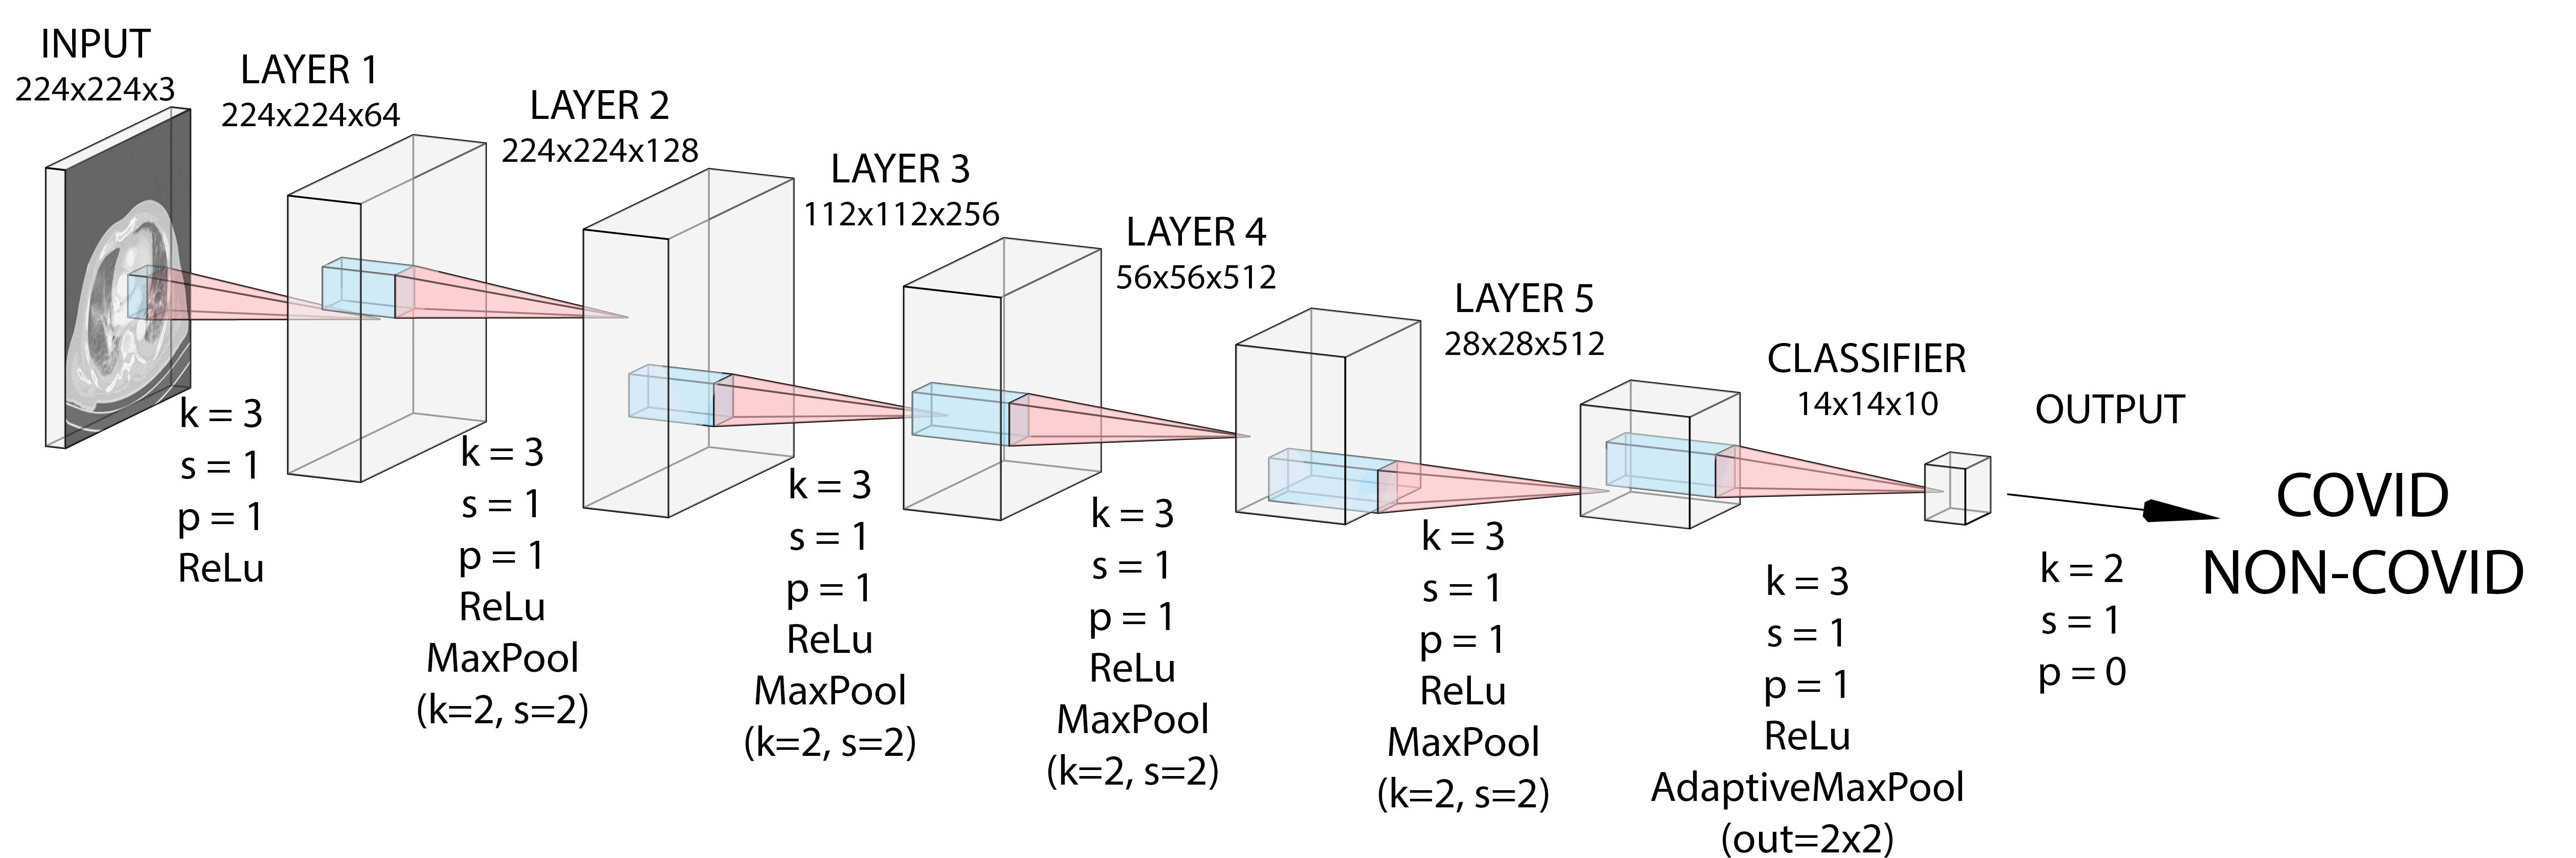

In [ ]:
class FCN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=2, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=512, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

*** My model FCN ***
FCN(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): AdaptiveMaxPool2d(output_size=2)
    (14): Conv2d(512, 2, kernel_size=(2, 2), stride=(1, 1))
  )
)


 test 1 : 100%|██████████| 1049/1049 [05:55<00:00,  2.95it/s]


Epoch 1: Training Loss=0.1219, Training Accuracy=0.9495, Validation Loss=1.0336, Validation Accuracy=0.8058, Test Loss=0.0846, Test Accuracy=0.9691


 test 2 : 100%|██████████| 1049/1049 [05:47<00:00,  3.02it/s]


Epoch 2: Training Loss=0.0286, Training Accuracy=0.9916, Validation Loss=0.9163, Validation Accuracy=0.7920, Test Loss=0.0254, Test Accuracy=0.9934


 test 3 : 100%|██████████| 1049/1049 [05:52<00:00,  2.97it/s]


Epoch 3: Training Loss=0.0196, Training Accuracy=0.9947, Validation Loss=1.0451, Validation Accuracy=0.8015, Test Loss=0.0164, Test Accuracy=0.9955


 test 4 : 100%|██████████| 1049/1049 [06:05<00:00,  2.87it/s]


Epoch 4: Training Loss=0.0152, Training Accuracy=0.9961, Validation Loss=0.9725, Validation Accuracy=0.8108, Test Loss=0.0113, Test Accuracy=0.9969


 test 5 : 100%|██████████| 1049/1049 [06:01<00:00,  2.90it/s]


Epoch 5: Training Loss=0.0117, Training Accuracy=0.9971, Validation Loss=1.1629, Validation Accuracy=0.8071, Test Loss=0.0111, Test Accuracy=0.9968


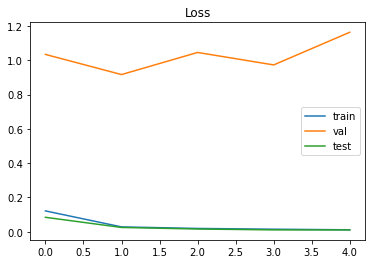

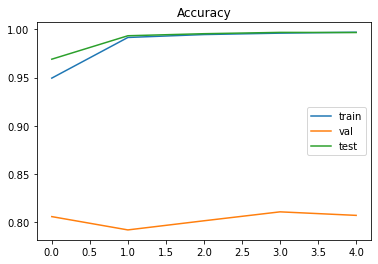


*** Best model: ***
          Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
4  My model FCN      4        0.996111      0.810769       0.996902

My model FCN - Confusion Matrix train set


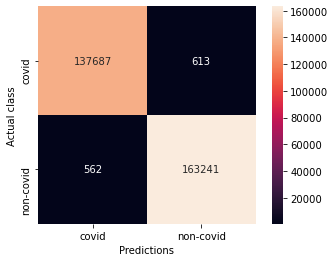

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00    138300
   non-covid       1.00      1.00      1.00    163803

    accuracy                           1.00    302103
   macro avg       1.00      1.00      1.00    302103
weighted avg       1.00      1.00      1.00    302103


My model FCN - Confusion Matrix val set


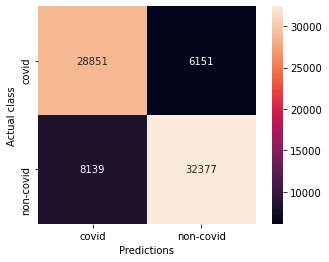

              precision    recall  f1-score   support

       covid       0.78      0.82      0.80     35002
   non-covid       0.84      0.80      0.82     40516

    accuracy                           0.81     75518
   macro avg       0.81      0.81      0.81     75518
weighted avg       0.81      0.81      0.81     75518


My model FCN - Confusion Matrix test set


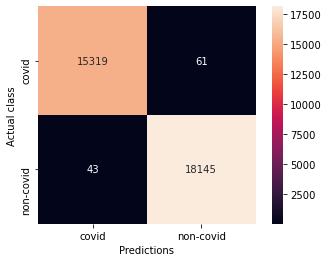

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00     15380
   non-covid       1.00      1.00      1.00     18188

    accuracy                           1.00     33568
   macro avg       1.00      1.00      1.00     33568
weighted avg       1.00      1.00      1.00     33568



<Figure size 432x288 with 0 Axes>

In [ ]:
print("*** My model FCN ***")
net = FCN()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

best_model_my_net = train(net, loaders, optimizer, criterion, epochs=5, dev=device, save_param = True, model_name = "My model FCN")

Until now we have used Accuracy as the only metric to evaluate the classification method, it is a number between 0 and 1 and measures how often the prediction is correct but it does not tell us in what way predictions are wrong, so it is considered as a rough measurement.

Precision (also called positive predictive value) tells us the percentage of our samples that were properly labeled positive, relative to all the samples labeled as positive.

Recall (also called sensitivity) tells us the percentage of positive samples that are correctly labeled.

f1 score is a combination of precision and recall (as harmonic mean) that allow us to evaluate the model when there are imbalanced classes (like in real-life classification problem).

As we can see the best model considering the validation accuracy is the 4th with Training and test set accuracy of 99.6% (taking into consideration that the test set is a subset of the training set), instead Validation accuracy is 81%.

### 3.3 VGG19

VGG stands for Visual Geometry Group from Oxford, it is composed by 19 convolutional layers with a 3 x 3 Kernel, max pool kernel of size 2x2 size with stride 2, and 3 fully connected layers used for classification. It has a total of about 143 million parameters.

<center>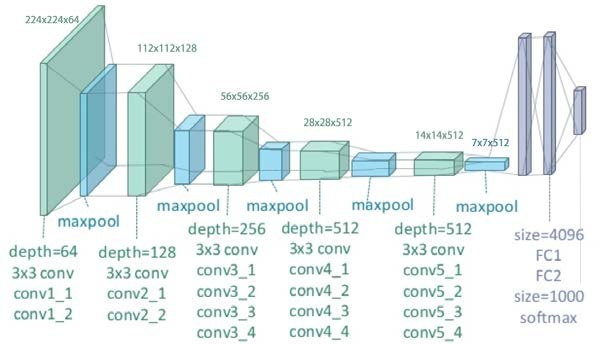

In [ ]:
vgg19 = models.vgg19(pretrained = True).to(device)

for param in vgg19.parameters():
  param.requires_grad = False

vgg19.classifier[6] = nn.Linear(in_features=4096, out_features = 2)

*** VGG19 ***
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), strid

 test 1 : 100%|██████████| 525/525 [06:03<00:00,  1.44it/s]


Epoch 1: Training Loss=0.6056, Training Accuracy=0.6771, Validation Loss=0.5782, Validation Accuracy=0.7077, Test Loss=0.5625, Test Accuracy=0.7207


 test 2 : 100%|██████████| 525/525 [06:13<00:00,  1.41it/s]


Epoch 2: Training Loss=0.5880, Training Accuracy=0.6927, Validation Loss=0.5779, Validation Accuracy=0.7106, Test Loss=0.5545, Test Accuracy=0.7269


 test 3 : 100%|██████████| 525/525 [06:12<00:00,  1.41it/s]


Epoch 3: Training Loss=0.5852, Training Accuracy=0.6938, Validation Loss=0.5730, Validation Accuracy=0.7151, Test Loss=0.5513, Test Accuracy=0.7310


 test 4 : 100%|██████████| 525/525 [06:23<00:00,  1.37it/s]


Epoch 4: Training Loss=0.5839, Training Accuracy=0.6954, Validation Loss=0.5771, Validation Accuracy=0.7139, Test Loss=0.5512, Test Accuracy=0.7310


 test 5 : 100%|██████████| 525/525 [06:27<00:00,  1.35it/s]


Epoch 5: Training Loss=0.5831, Training Accuracy=0.6966, Validation Loss=0.5741, Validation Accuracy=0.7084, Test Loss=0.5514, Test Accuracy=0.7246


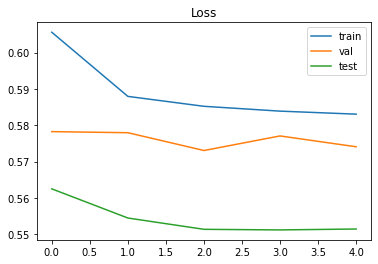

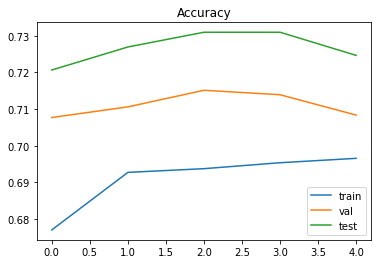


*** Best model: ***
   Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
3  VGG19      3        0.693755      0.715129       0.730952

VGG19 - Confusion Matrix train set


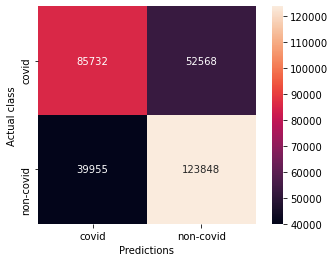

              precision    recall  f1-score   support

       covid       0.68      0.62      0.65    138300
   non-covid       0.70      0.76      0.73    163803

    accuracy                           0.69    302103
   macro avg       0.69      0.69      0.69    302103
weighted avg       0.69      0.69      0.69    302103


VGG19 - Confusion Matrix val set


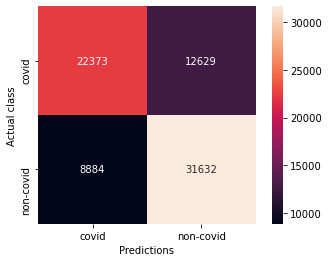

              precision    recall  f1-score   support

       covid       0.72      0.64      0.68     35002
   non-covid       0.71      0.78      0.75     40516

    accuracy                           0.72     75518
   macro avg       0.72      0.71      0.71     75518
weighted avg       0.72      0.72      0.71     75518


VGG19 - Confusion Matrix test set


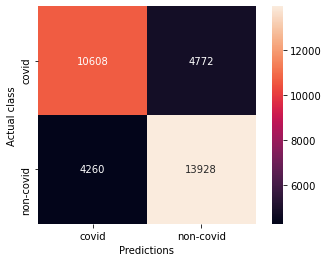

              precision    recall  f1-score   support

       covid       0.71      0.69      0.70     15380
   non-covid       0.74      0.77      0.76     18188

    accuracy                           0.73     33568
   macro avg       0.73      0.73      0.73     33568
weighted avg       0.73      0.73      0.73     33568



<Figure size 432x288 with 0 Axes>

In [ ]:
print("*** VGG19 ***")
optimizer = torch.optim.Adam(vgg19.parameters(), lr = 0.0001)

best_model_vgg19 = train(vgg19, loaders, optimizer, criterion, epochs=5, dev=device, save_param = True, model_name = "VGG19")

As we can see the best model considering the validation accuracy is the 3rd with Training set accuracy of 69.38%, Validation 71.51% and Test of 73%.

### 3.4 ResNet-152

To avoid the problem of vanishing/exploding gradients ResNet uses the so Residual Block which is a residual mapping layer copied from the shallower layer.
All convolutional layers apply the same convolutional window of size 3 × 3, the number of filters increases following the depth of networks, from 64 to 2048.
There is only one max-pooling layer with pooling size 3 × 3, and a stride of 2 is applied after the first layer. The average pooling layer is applied to replace fully connected layers at the end of the architecture. It has 60 million of parameters.

<center>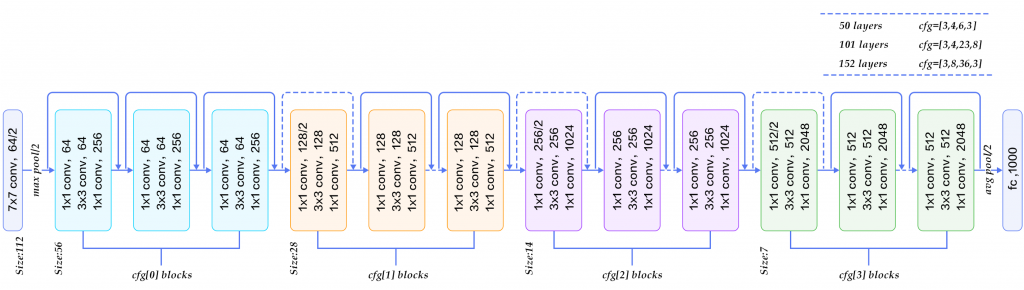

In [ ]:
resnet152 = models.resnet152(pretrained=True).to(device)

for param in resnet152.parameters():
  param.requires_grad = False

resnet152.fc = nn.Linear(in_features=2048, out_features = 2)

*** ResNet-152 ***
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=

 test 1 : 100%|██████████| 525/525 [06:01<00:00,  1.45it/s]


Epoch 1: Training Loss=0.5636, Training Accuracy=0.7139, Validation Loss=0.5671, Validation Accuracy=0.7171, Test Loss=0.5346, Test Accuracy=0.7363


 test 2 : 100%|██████████| 525/525 [06:03<00:00,  1.44it/s]


Epoch 2: Training Loss=0.5314, Training Accuracy=0.7385, Validation Loss=0.5701, Validation Accuracy=0.7138, Test Loss=0.5238, Test Accuracy=0.7455


 test 3 : 100%|██████████| 525/525 [06:02<00:00,  1.45it/s]


Epoch 3: Training Loss=0.5191, Training Accuracy=0.7483, Validation Loss=0.5592, Validation Accuracy=0.7237, Test Loss=0.5085, Test Accuracy=0.7582


 test 4 : 100%|██████████| 525/525 [05:58<00:00,  1.46it/s]


Epoch 4: Training Loss=0.5096, Training Accuracy=0.7552, Validation Loss=0.5578, Validation Accuracy=0.7240, Test Loss=0.5015, Test Accuracy=0.7624


 test 5 : 100%|██████████| 525/525 [05:53<00:00,  1.49it/s]


Epoch 5: Training Loss=0.5029, Training Accuracy=0.7603, Validation Loss=0.5472, Validation Accuracy=0.7330, Test Loss=0.4902, Test Accuracy=0.7701


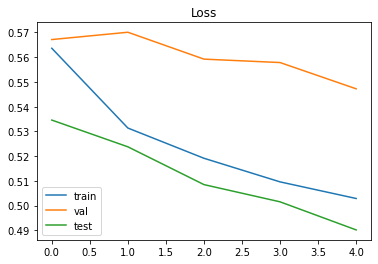

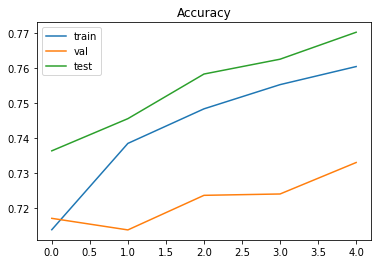


*** Best model: ***
        Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
5  ResNet-152      5        0.760347      0.733011       0.770119

ResNet-152 - Confusion Matrix train set


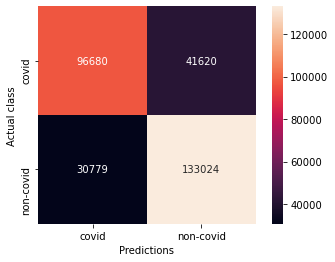

              precision    recall  f1-score   support

       covid       0.76      0.70      0.73    138300
   non-covid       0.76      0.81      0.79    163803

    accuracy                           0.76    302103
   macro avg       0.76      0.76      0.76    302103
weighted avg       0.76      0.76      0.76    302103


ResNet-152 - Confusion Matrix val set


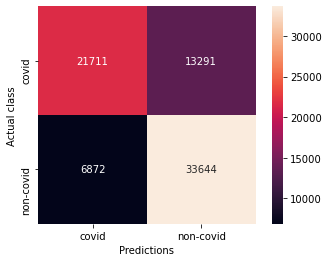

              precision    recall  f1-score   support

       covid       0.76      0.62      0.68     35002
   non-covid       0.72      0.83      0.77     40516

    accuracy                           0.73     75518
   macro avg       0.74      0.73      0.73     75518
weighted avg       0.74      0.73      0.73     75518


ResNet-152 - Confusion Matrix test set


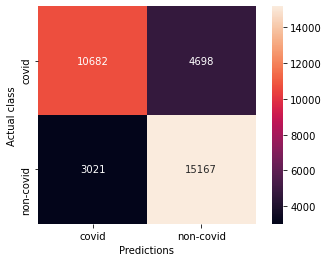

              precision    recall  f1-score   support

       covid       0.78      0.69      0.73     15380
   non-covid       0.76      0.83      0.80     18188

    accuracy                           0.77     33568
   macro avg       0.77      0.76      0.77     33568
weighted avg       0.77      0.77      0.77     33568



<Figure size 432x288 with 0 Axes>

In [ ]:
print("*** ResNet-152 ***")
optimizer = torch.optim.Adam(resnet152.parameters(), lr = 0.0001)
best_model_resnet152 = train(resnet152, loaders, optimizer, criterion, epochs=5, dev=device, save_param = True, model_name = "ResNet-152")

As we can see the best model considering the validation accuracy is the 5th with Training set accuracy of 76%, Validation 73.30% and Test of 77%.

### 3.5 DenseNet-161

Quite differently from ResNet, in DenseNet for each layer the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. This alleviates the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. It is composed by a 7x7 convolutional layer with stride 2, then max pool 3x3 with stride 2, and then a series of dense blocks and transition layers. The classification layer is created by a 7x7 global average pool with a 1000D fully connected. It has 29 million of parameters.

<center>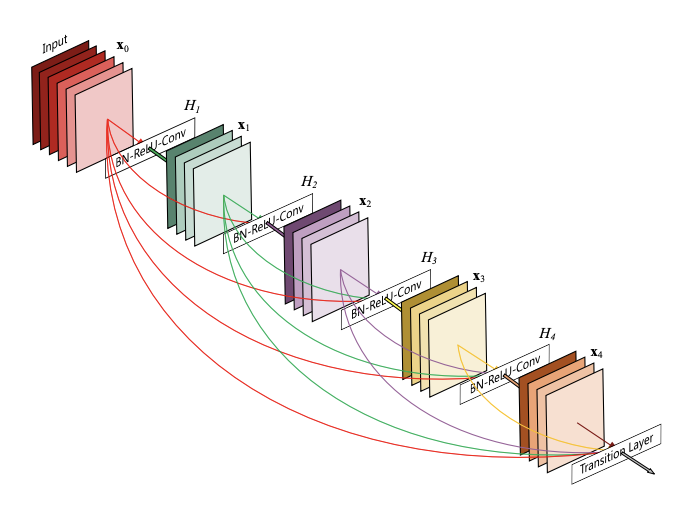

In [ ]:
densenet161 = models.densenet161(pretrained=True).to(device)

for param in densenet161.parameters():
  param.requires_grad = False

densenet161.classifier = nn.Linear(in_features=2208, out_features = 2)

*** DenseNet-161 ***
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_sta

 test 1 : 100%|██████████| 525/525 [06:01<00:00,  1.45it/s]


Epoch 1: Training Loss=0.5348, Training Accuracy=0.7375, Validation Loss=0.5367, Validation Accuracy=0.7381, Test Loss=0.4925, Test Accuracy=0.7699


 test 2 : 100%|██████████| 525/525 [05:52<00:00,  1.49it/s]


Epoch 2: Training Loss=0.4919, Training Accuracy=0.7674, Validation Loss=0.5380, Validation Accuracy=0.7363, Test Loss=0.4753, Test Accuracy=0.7787


 test 3 : 100%|██████████| 525/525 [06:05<00:00,  1.44it/s]


Epoch 3: Training Loss=0.4802, Training Accuracy=0.7734, Validation Loss=0.5408, Validation Accuracy=0.7375, Test Loss=0.4664, Test Accuracy=0.7822


 test 4 : 100%|██████████| 525/525 [06:04<00:00,  1.44it/s]


Epoch 4: Training Loss=0.4749, Training Accuracy=0.7766, Validation Loss=0.5423, Validation Accuracy=0.7348, Test Loss=0.4638, Test Accuracy=0.7827


 test 5 : 100%|██████████| 525/525 [06:05<00:00,  1.44it/s]


Epoch 5: Training Loss=0.4713, Training Accuracy=0.7774, Validation Loss=0.5495, Validation Accuracy=0.7334, Test Loss=0.4618, Test Accuracy=0.7843


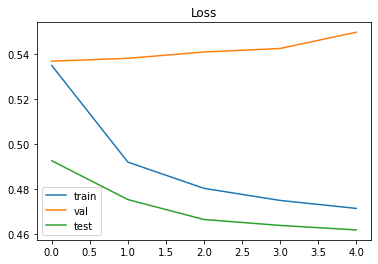

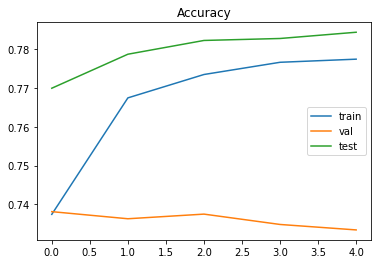


*** Best model: ***
          Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
1  DenseNet-161      1        0.737452      0.738148       0.769911

DenseNet-161 - Confusion Matrix train set


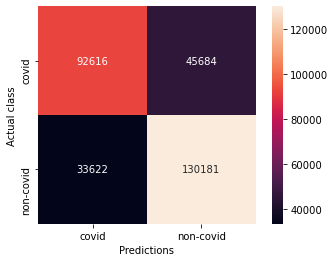

              precision    recall  f1-score   support

       covid       0.73      0.67      0.70    138300
   non-covid       0.74      0.79      0.77    163803

    accuracy                           0.74    302103
   macro avg       0.74      0.73      0.73    302103
weighted avg       0.74      0.74      0.74    302103


DenseNet-161 - Confusion Matrix val set


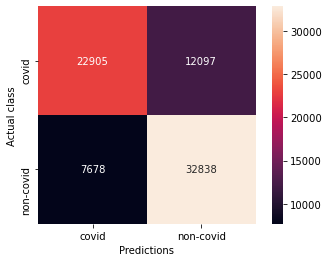

              precision    recall  f1-score   support

       covid       0.75      0.65      0.70     35002
   non-covid       0.73      0.81      0.77     40516

    accuracy                           0.74     75518
   macro avg       0.74      0.73      0.73     75518
weighted avg       0.74      0.74      0.74     75518


DenseNet-161 - Confusion Matrix test set


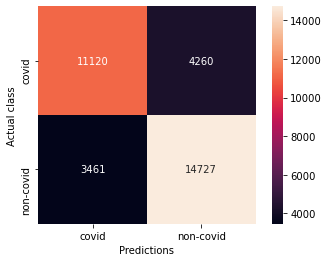

              precision    recall  f1-score   support

       covid       0.76      0.72      0.74     15380
   non-covid       0.78      0.81      0.79     18188

    accuracy                           0.77     33568
   macro avg       0.77      0.77      0.77     33568
weighted avg       0.77      0.77      0.77     33568



<Figure size 432x288 with 0 Axes>

In [ ]:
print("*** DenseNet-161 ***")
optimizer = torch.optim.Adam(densenet161.parameters(), lr = 0.0001)
best_model_densenet161 = train(densenet161, loaders, optimizer, criterion, epochs=5, dev=device, save_param = True, model_name = "DenseNet-161")

As we can see the best model considering the validation accuracy is the 1st with Training set accuracy of 73.74%, Validation 73.81% and Test of 77%.

## 4. Best model

This table should be useful to summirize the accuracy over the models, we selected the best model for the best epoch for each of the all architecures.

In [ ]:
results = pd.concat([best_model_my_net, best_model_vgg19, best_model_resnet152, best_model_densenet161])
results = results.sort_values(by=['Val Accuracy'], ascending=False)
print(results.to_string(index=False))

       Model  Epoch  Train Accuracy  Val Accuracy  Test Accuracy
My model FCN      4        0.996111      0.810769       0.996902
DenseNet-161      1        0.737452      0.738148       0.769911
  ResNet-152      5        0.760347      0.733011       0.770119
       VGG19      3        0.693755      0.715129       0.730952


As we can see the best architecure is our, with an accuracy on the training set of 99.61%, validation 81.08% and test set 99.69%.

## 4.1 Inference

In this section we try to make prediction over an internal dataset of ct scan slices brought by Azienda Ospedaliero Universitaria Policlinico "G. Rodolico - San Marco".

First we need to download the ct scan files:

In [ ]:
!gsutil cp gs://covid_19_challenge/dati_palmucci_pred.zip .
!unzip -q dati_palmucci_pred.zip
!rm -f dati_palmucci_pred.zip

Copying gs://covid_19_challenge/dati_palmucci_pred.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  1.9 GiB/  1.9 GiB]   27.8 MiB/s                                   
Operation completed over 1 objects/1.9 GiB.                                      


In [ ]:
dir = './dati_palmucci_pred/'

Here we describe the prediction dataset:

In [ ]:
patients = len(os.listdir(dir))
print("Number of patients: ", patients)
slices = sum(len(files) for _, _, files in os.walk(dir))
print("Total number of slices: ", slices)
avg_slices = round(slices/patients)
print("Average number of slices per patient: ", avg_slices)

Number of patients:  49
Total number of slices:  14635
Average number of slices per patient:  299


So now we can select the ct scan of a patient (i.e. the folder that contains .jpg slices), for example ct_scan_21:

In [ ]:
dir_pred = './dati_palmucci_pred/ct_scan_21/'

Load the best model, in our case the Fully Convolutional one:

In [ ]:
best_model = FCN()
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('./My model FCN_best_val.pth'))
best_model.eval()

FCN(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): AdaptiveMaxPool2d(output_size=2)
    (14): Conv2d(512, 2, kernel_size=(2, 2), stride=(1, 1))
  )
)

And now we can make predictions:

In [ ]:
# A function to natural sort files inside the ct scan folder
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [ ]:
count_covid = 0
count_non_covid = 0

filename_list = []
positive_negative = []

filename_slices = [file for _, _, file in os.walk(dir_pred)]
filename_slices = natural_sort(filename_slices[0])

for i in range(len(filename_slices)):
    filename_list.append(filename_slices[i])
        
    image = Image.open(dir_pred+filename_slices[i]).convert("RGB").resize((224, 224), Image.ANTIALIAS)
    image = ToTensor()(image)
    #plt.imshow(image.permute(1, 2, 0))
    
    image = T.Normalize(0.5, 0.5)(image)
    image = (image.unsqueeze(dim=0)).to(device)
    pred = best_model(image)
    _, pred_label  = pred.max(1)
        
    if pred_label[0].item() == 0:
        positive_negative.append('covid')
        count_covid += 1
    else:
        positive_negative.append('non-covid')
        count_non_covid += 1
        
print(f'Number of Covid slices: {count_covid}/{len(filename_slices)}\nNumber of Non-Covid slices: {count_non_covid}/{len(filename_slices)}')

slices_result = { "Slice": filename_list, "Result": positive_negative}
slices_result = pd.DataFrame(slices_result)

Number of Covid slices: 63/166
Number of Non-Covid slices: 103/166


If we want to visualize dynamically slices and the corresponding result:

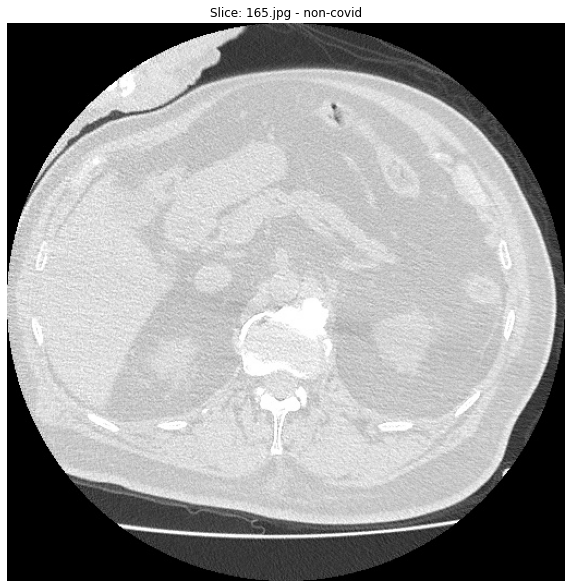

In [ ]:
plt.figure()
for i in range(len(slices_result)):
    img = cv2.imread(dir_pred + slices_result['Slice'].iloc[i])[:,:,::-1]   # Reads an image in the BGR format to RGB
    
    fig = plt.figure(figsize=(10,15))
    plt.axis("off")
    plt.imshow(img)
    plt.title(f'Slice: %s - %s' %(slices_result['Slice'].iloc[i], slices_result['Result'].iloc[i]))
    plt.show()
    
    time.sleep(0.3)
    
    clear_output(wait=True)